### Number of images to generate

In [1]:
n = 2

### Path to images

In [2]:
path = './Cover/'

### Imports

In [3]:
import rawpy
from rawkit.raw import Raw

import numpy as np
from numpy import cos
import PIL
from PIL import Image as ImagePIL
import time
import multiprocessing
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool as Pool
import glob
import sys
import scipy
from imageio import imwrite, imread

from numpy.random import RandomState

import pickle
from jpeg import jpeg
from jpeg import base
import gc
from scipy.fftpack import dct, idct
import skimage.io
import os

from time import time

import matplotlib.pyplot as plt

[pysteg.jpeg] $Id: __init__.py 2204 2011-04-05 11:43:38Z georg $


### Déclarations

In [4]:
# Quant table at QF=100 (convert)
c_quant_100 = np.array([\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1],\
        [ 1,  1,  1,  1,  1, 1, 1, 1]])


# Quant table at QF=95 (convert)
c_quant_95 = np.array([\
        [ 2,  1,  1,  2,  2,  4,  5,  6],\
        [ 1,  1,  1,  2,  3,  6,  6,  6],\
        [ 1,  1,  2,  2,  4,  6,  7,  6],\
        [ 1,  2,  2,  3,  5,  9,  8,  6],\
        [ 2,  2,  4,  6,  7, 11, 10,  8],\
        [ 2,  4,  6,  6,  8, 10, 11,  9],\
        [ 5,  6,  8,  9, 10, 12, 12, 10],\
        [ 7,  9, 10, 10, 11, 10, 10, 10]])


# Quant table at QF=85 (convert)
c_quant_85 = np.array([\
     [ 5,  3,  3,  5,  7, 12, 15, 18],\
     [ 4,  4,  4,  6,  8, 17, 18, 17],\
     [ 4,  4,  5,  7, 12, 17, 21, 17],\
     [ 4,  5,  7,  9, 15, 26, 24, 19],\
     [ 5,  7, 11, 17, 20, 33, 31, 23],\
     [ 7, 11, 17, 19, 24, 31, 34, 28],\
     [15, 19, 23, 26, 31, 36, 36, 30],\
     [22, 28, 29, 29, 34, 30, 31, 30]])

# Quant table at QF=75 (convert)
c_quant_75 = np.array([\
        [ 8,  6,  5,  8, 12, 20, 26, 31],\
        [ 6,  6,  7, 10, 13, 29, 30, 28],\
        [ 7,  7,  8, 12, 20, 29, 35, 28],\
        [ 7,  9, 11, 15, 26, 44, 40, 31],\
        [ 9, 11, 19, 28, 34, 55, 52, 39],\
        [12, 18, 28, 32, 41, 52, 57, 46],\
        [25, 32, 39, 44, 52, 61, 60, 51],\
        [36, 46, 48, 49, 56, 50, 52, 50]])

# Postprocess parameters
params = rawpy.Params(rawpy.DemosaicAlgorithm.LINEAR, half_size=False, four_color_rgb=False, use_camera_wb=False, \
                      use_auto_wb=False, user_wb=(1,1,1,1), output_color=rawpy.ColorSpace.raw, output_bps=16, \
                      user_flip=None, user_black=0, user_sat=None, no_auto_bright=True, auto_bright_thr=None, \
                      adjust_maximum_thr=0.0, bright=1.0, highlight_mode=rawpy.HighlightMode.Clip, exp_shift=None, \
                      exp_preserve_highlights=0.0, no_auto_scale=False, gamma=(1,1), chromatic_aberration=None, \
                      bad_pixels_path=None)

### Conversion functions

In [5]:
def dct2(x):
    return dct(dct(x, norm='ortho').T, norm='ortho').T
    
def idct2(x):
    return idct(idct(x, norm='ortho').T, norm='ortho').T

# Compute the DCT quantized coefficients from a 16bits coded image
def compute_jpeg_domain(im_pix, QF):
    """
    Compress the image into JPEG (simulations)
    """
    
    if QF == 75:
      c_quant = c_quant_75
    elif QF == 85:
      c_quant = c_quant_85
    elif QF == 95:
      c_quant = c_quant_95
    elif QF == 100:
      c_quant = c_quant_100

    w,h = im_pix.shape
    
    dct_im = np.zeros((w,h))
    for bind_i in range(w//8):
        for bind_j in range(h//8):
            im_bloc = im_pix[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8]
            dct_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8] = np.round(dct2(im_bloc - 2**15-64)/(c_quant*256))
    dct_im = dct_im.astype(np.int32)
                           
    return dct_im

# Compute DCT-Quantized coefficients from NON-quantized ones 
def compute_jpeg_from_dct(dct_im,c_quant):
    """
    Compute the jpeg representation from the DCT coefficients 
    """
    w,h = dct_im.shape
    jpeg_im = np.zeros((w,h))
    for bind_i in range(w//8):
        for bind_j in range(h//8):
            dct_bloc = dct_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8]
            jpeg_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8] = \
            np.round(dct_bloc/(c_quant*256))
    jpeg_im = jpeg_im.astype(np.int32)
    
    return jpeg_im

# Convert a TIFF image coded in 16 bits to a greyscale matrix coding in 16 bits too
def tiff2grey_16(imagefile):
    img = skimage.io.imread(imagefile+'.tiff', plugin='tifffile')
    img_grey = (img[:,:,0]).astype('uint32') * 299/1000 + (img[:,:,1]).astype('uint32') * 587/1000 + (img[:,:,2]).astype('uint32') * 114/1000
    img_grey[img_grey>2**16-1]=2**16-1
    return(img_grey.astype(np.int32))


def compute_dct_domain(im_pix):
    """
    Convert the image into DCT coefficients without performing quantization
    """
    w,h = im_pix.shape
    dct_im = np.zeros((w,h))
    for bind_i in range(w//8):
        for bind_j in range(h//8):
            im_bloc = im_pix[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8]
            dct_im[bind_i*8:(bind_i+1)*8,bind_j*8:(bind_j+1)*8] = dct2(im_bloc-2**15-64)
    return dct_im

def raw_to_dct(raw,imagefile):
    rgb = raw.postprocess(params)
    skimage.io.imwrite(imagefile+'.tiff', rgb)
    im_grey = tiff2grey_16(imagefile)
    dct_im = compute_dct_domain(im_grey)
    os.remove(imagefile+'.tiff')
    return(dct_im)

def raw_to_jpeg_python(raw,imagefile):
    
    QF = conf.imgs.QF

    rgb = raw.postprocess(params)

    if not conf.generate.NS.mono :
        skimage.io.imsave(imagefile+'.tiff', rgb)        
        tmp = tiff2grey_16(imagefile)
        im_grey =tmp[x:x+512,y:y+512]
    else:
        im_grey = rgb[x:x+512,y:y+512,0].astype(np.int32)
   
    if(QF==75):
        s_struct = jpeg('./skeleton_75.jpg')
    elif(QF==85):
        s_struct = jpeg('./skeleton_85.jpg')
    elif(QF==95):
        s_struct = jpeg('./skeleton_95.jpg')
    elif(QF==100):
        s_struct = jpeg('./skeleton_100.jpg')
    
    jpg_im = compute_jpeg_domain(im_grey, QF)

    s_struct.coef_arrays[0] = jpg_im
    
    s_struct.save(imagefile + '.jpg')
    
    if not conf.generate.NS.mono :
        os.remove(imagefile+'.tiff')

### Classes

In [6]:
class conf(object):
    class generate(object):
        class NS(object):
            class jpeg(object):
                pass
            class dev(object):
                pass
            class mono(object):
                pass
    class embed(object):
        class NS(object):
            class a(object):
                pass
            class b(object):
                pass
        class stego_path:
            pass
        class cover_path:
            pass

    class imgs(object):
        class QF(object):
            pass

### Convert coordinates from RAW to JPEG

In [7]:
def seek_co():
    
    orientation = Raw(cover_file).metadata.orientation
    
    if orientation == 0:
        return x1, y1
   
    h, w = raw_im.raw_image_visible.shape
    
    if orientation == 5:
        x = w - y2
        y = x1
    elif orientation == 6:
        x = y1
        y = h - x2
    else:
        print("Orientation non reconnue")
        return None
    
    return x,y

### Create pseudo cover image n° i

In [8]:
def make_pseudo_cover(i):
    
    print(i)
    
    seed = hash(cover_file[-9:-4])%(2**32-i)

    np.random.seed(seed)

    raw_im = rawpy.imread(cover_file)
    im_cover = raw_im.raw_image_visible

    A = np.random.randn(512, 512)

    sens_noise = A * var_pseudo_cover_signal

    im_pseudo_cover[:,:] = im_cover[x1:x2,y1:y2] + sens_noise

    im_pseudo_cover[im_pseudo_cover>lvl_max]=lvl_max
    im_pseudo_cover[im_pseudo_cover<0]=0
    
    raw_im.raw_image_visible[x1:x2,y1:y2] = im_pseudo_cover[:,:]

    base_name = os.path.basename(cover_file)
    pseudo_cover_file = conf.embed.pseudo_cover_path + base_name[0:-4] + '_' + str(i)
    
    raw_to_jpeg_python(raw_im,pseudo_cover_file)

### Generate n images

In [9]:
def generate_pool(n):

    u = time()
    
    nb_cores = cpu_count()
    pool = Pool(nb_cores)
    
    pool.map(make_pseudo_cover, range(n))
    pool.close()
    pool.join()
                
    print("Temps :", time() - u)

#### File names (path)

In [10]:
files_list = os.listdir(path)
print(files_list)

['4468.cr2', '4959.pef', 'Mono4.DNG', 'Mono5.DNG', 'Mono1.DNG', '3280.cr2', '6934.nef', '4750.cr2', 'Mono3.DNG', 'Mono2.DNG']


Calcul du temps

In [11]:
u = time()

#### 4468.cr2

4468.cr2
Coordonnées RAW : (1500, 3300)
Coordonnées JPEG : (478, 1500)
01

Temps : 3.371523141860962


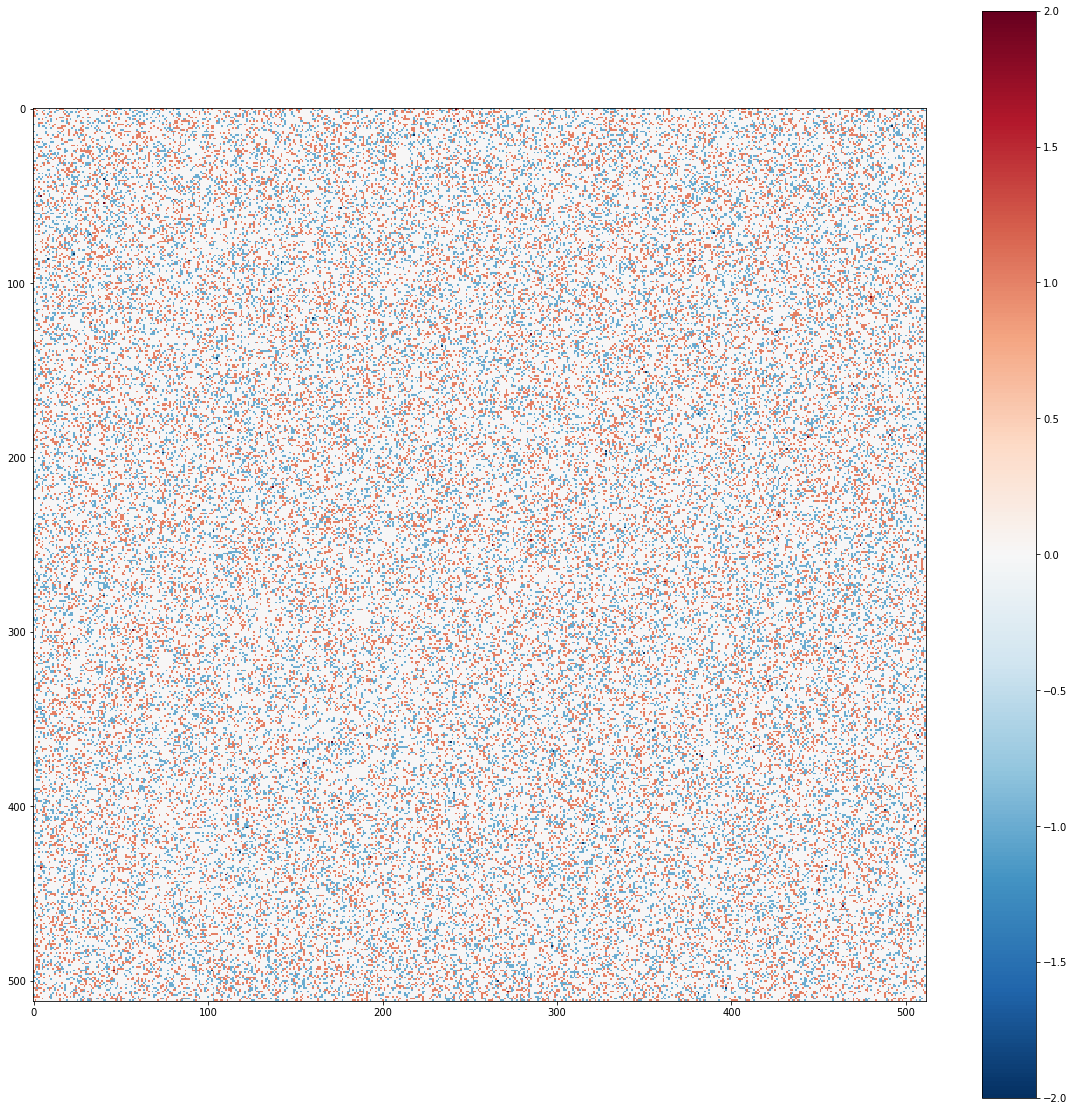

In [12]:
file = '4468.cr2'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1500
x2 = x1 + 512
y1 = 3300
y2 = y1 + 512

im_cover = np.copy(raw_im.raw_image_visible[x1:x2,y1:y2])

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = np.copy(raw_im.raw_image_visible[x1:x2,y1:y2])

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 4595.pef

4959.pef
Coordonnées RAW : (1200, 3000)
Coordonnées JPEG : (1200, 3000)
01

Temps : 2.8926210403442383


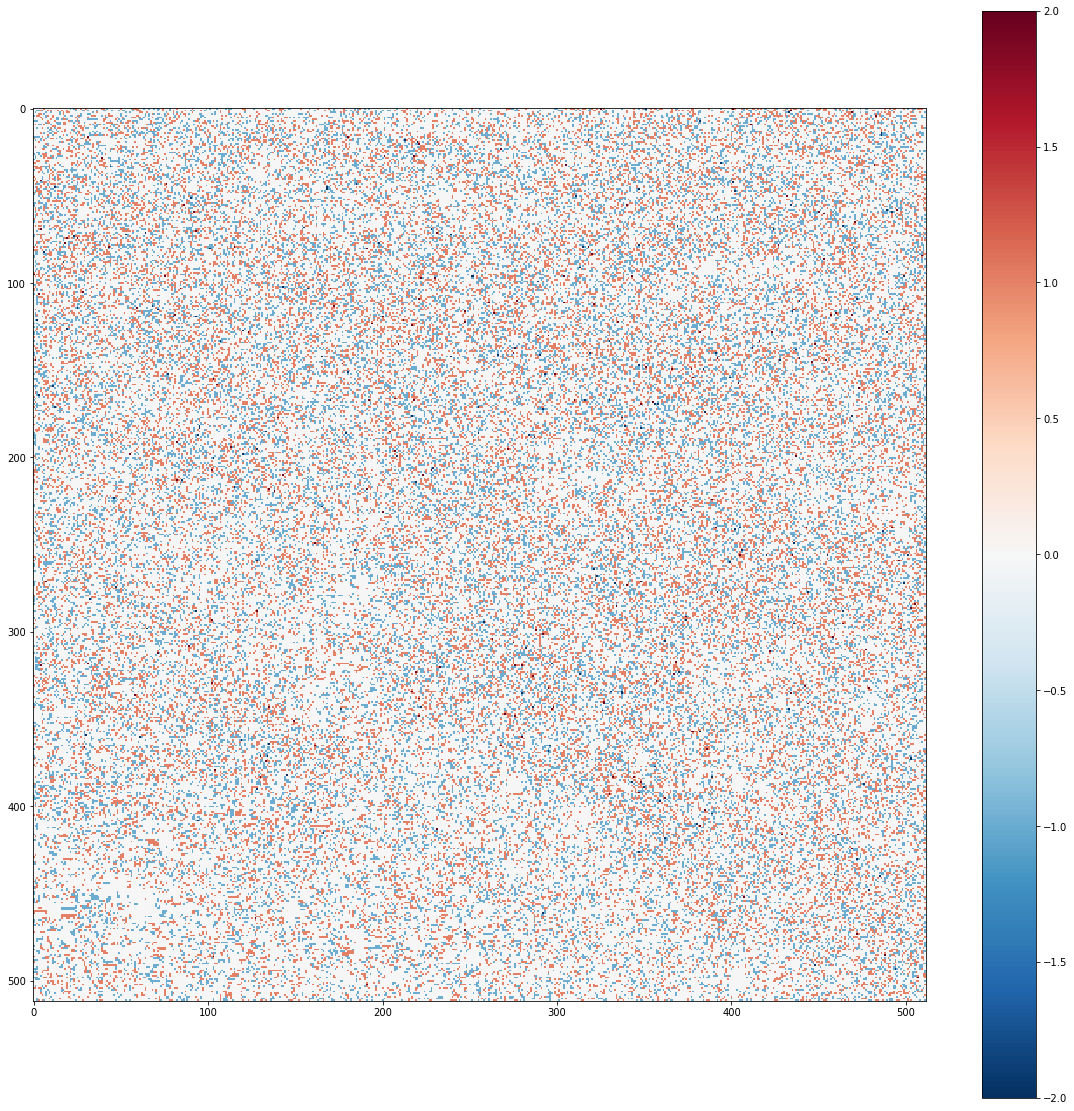

In [13]:
file = '4959.pef'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = False
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1200
x2 = x1 + 512
y1 = 3000
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono4.DNG

Mono4.DNG
Coordonnées RAW : (1200, 1000)
Coordonnées JPEG : (1200, 1000)
0
1
Temps : 1.20982027053833


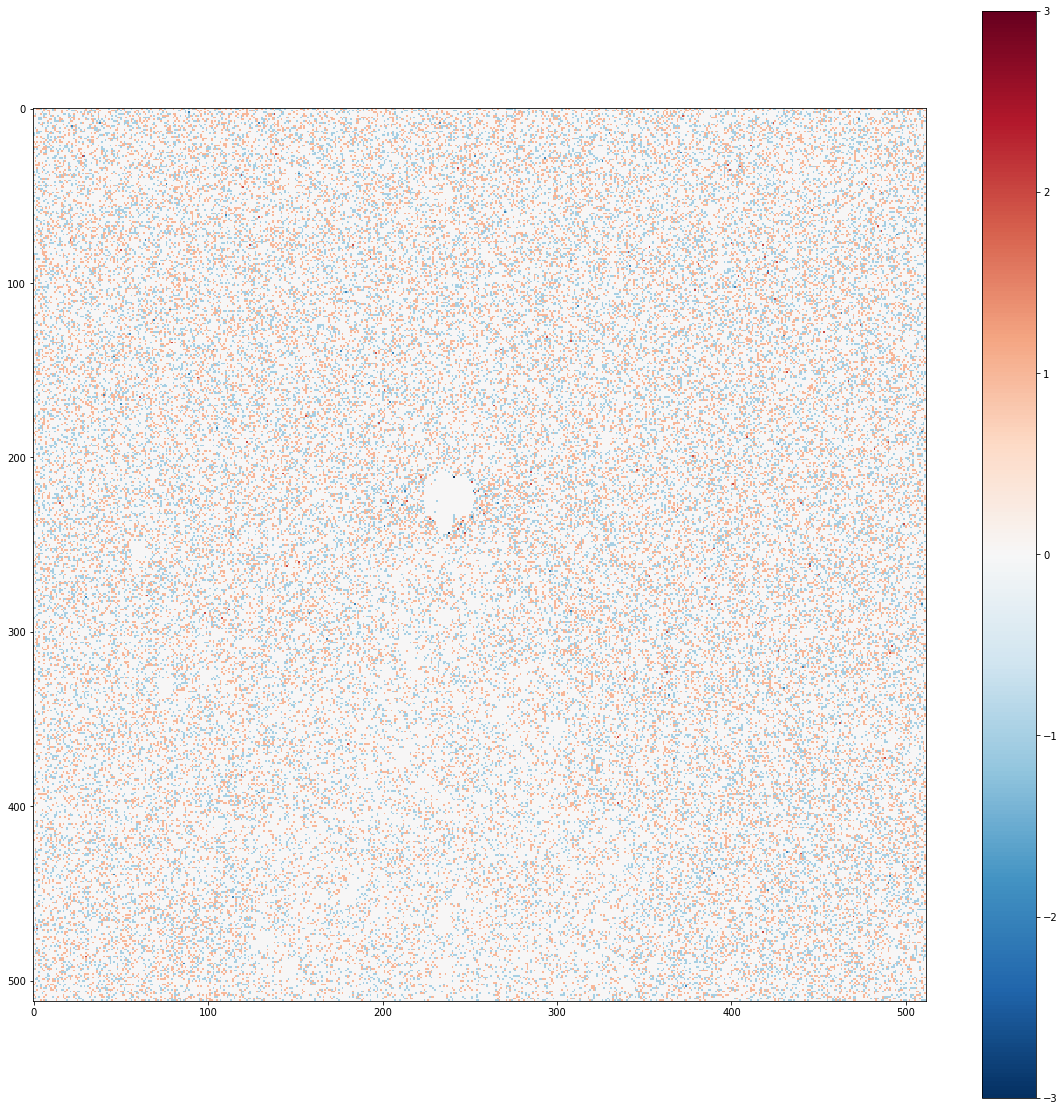

In [14]:
file = 'Mono4.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1200
x2 = x1 + 512
y1 = 1000
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono5.DNG

Mono5.DNG
Coordonnées RAW : (1800, 3000)
Coordonnées JPEG : (3000, 1160)
01

Temps : 1.4151322841644287


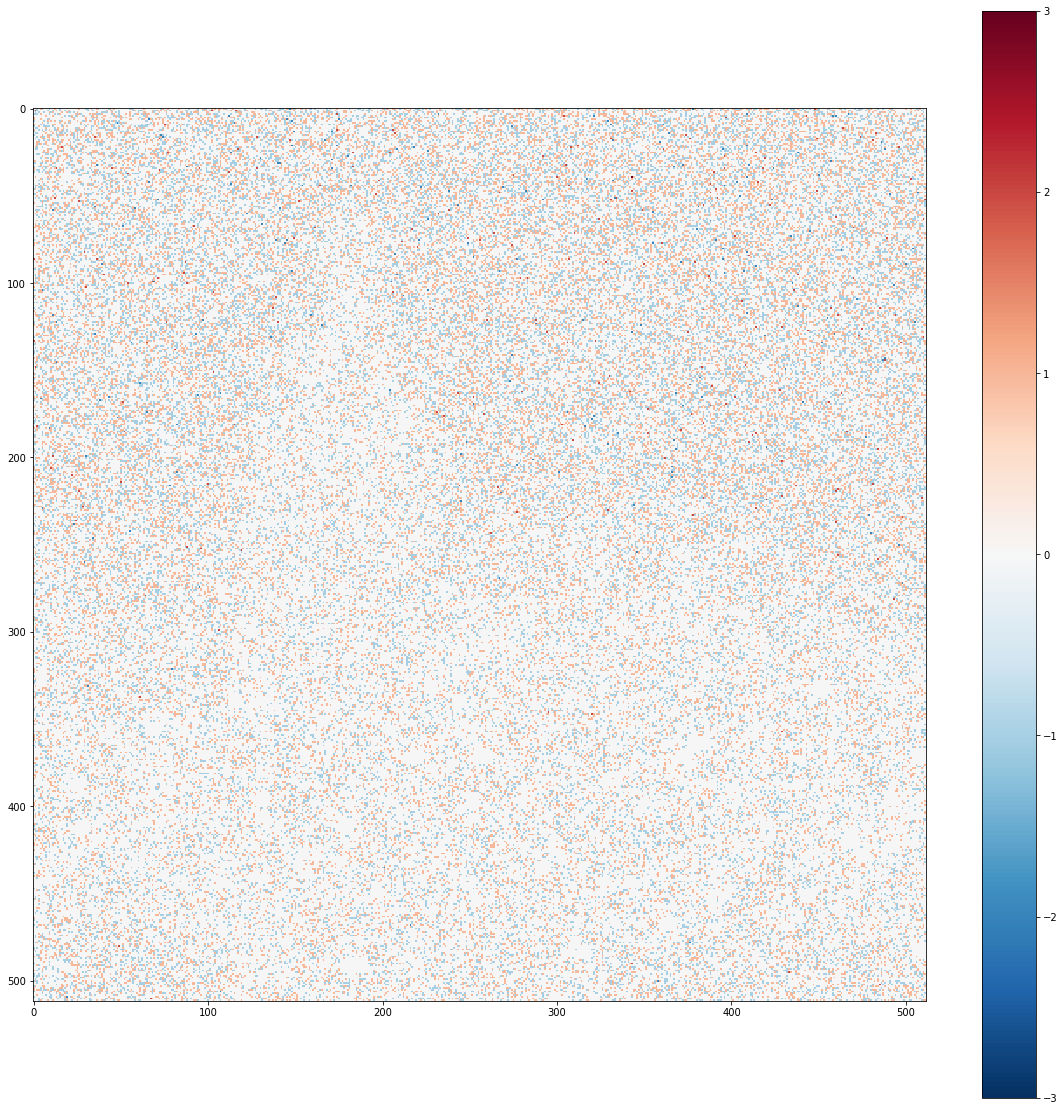

In [15]:
file = 'Mono5.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1800
x2 = x1 + 512
y1 = 3000
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono1.DNG

Mono1.DNG
Coordonnées RAW : (900, 2500)
Coordonnées JPEG : (900, 2500)
01

Temps : 1.2370574474334717


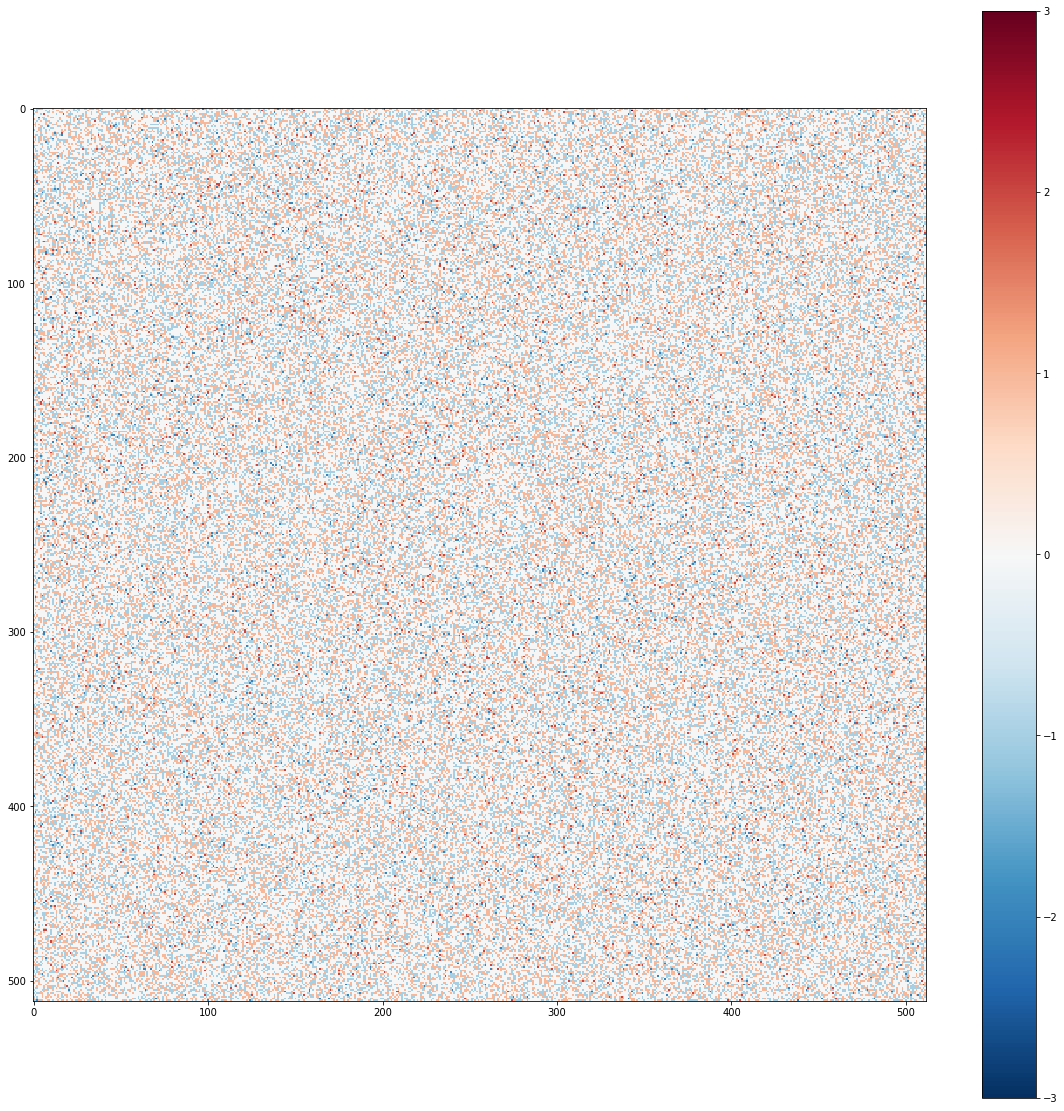

In [16]:
file = 'Mono1.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 900
x2 = x1 + 512
y1 = 2500
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 3280.cr2

3280.cr2
Coordonnées RAW : (740, 3350)
Coordonnées JPEG : (428, 740)
0
1
Temps : 2.318084716796875


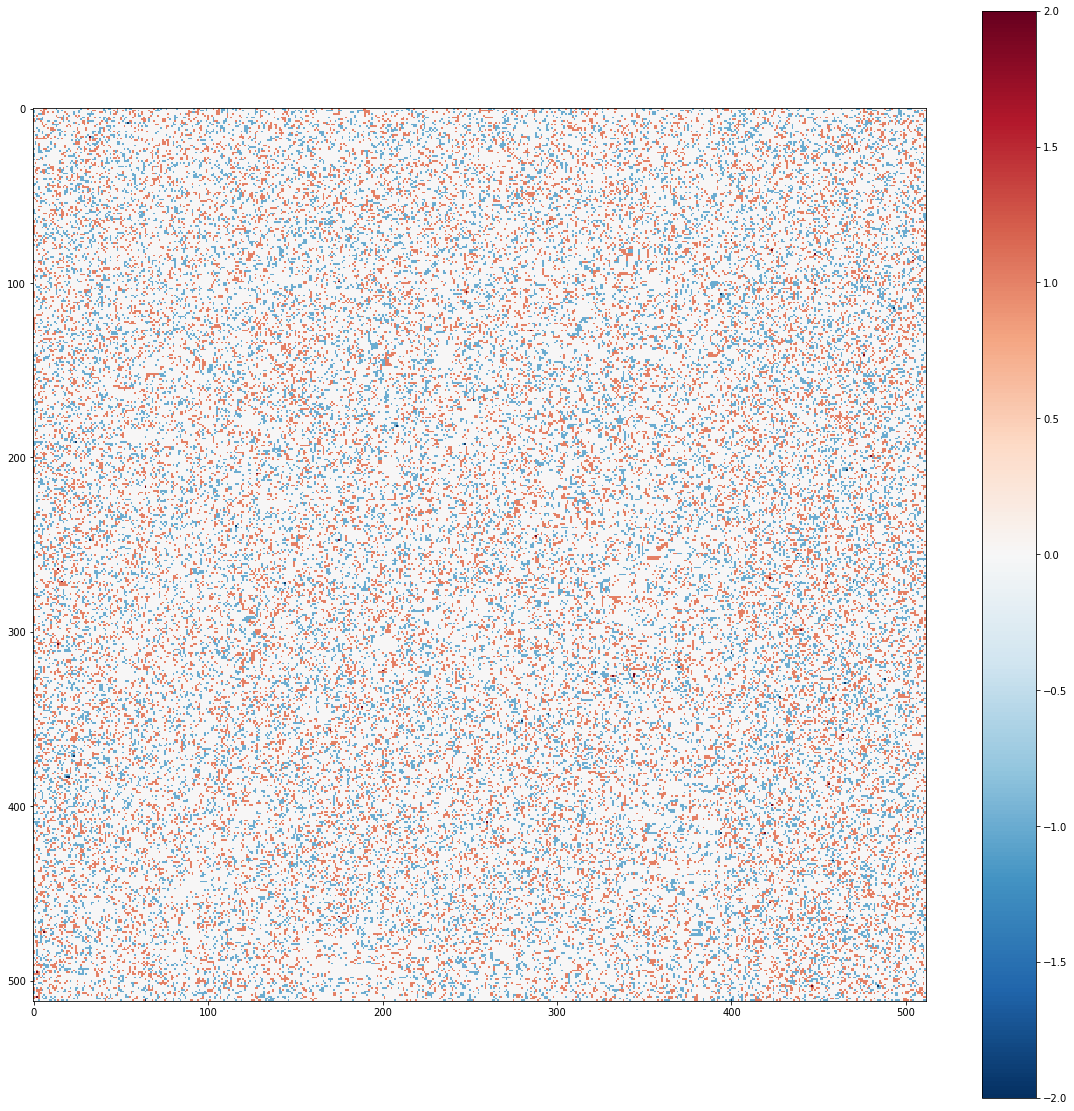

In [17]:
file = '3280.cr2'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 740
x2 = x1 + 512
y1 = 3350
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 6934.nef

6934.nef
Coordonnées RAW : (100, 500)
Coordonnées JPEG : (100, 500)
0
1
Temps : 1.24934720993042


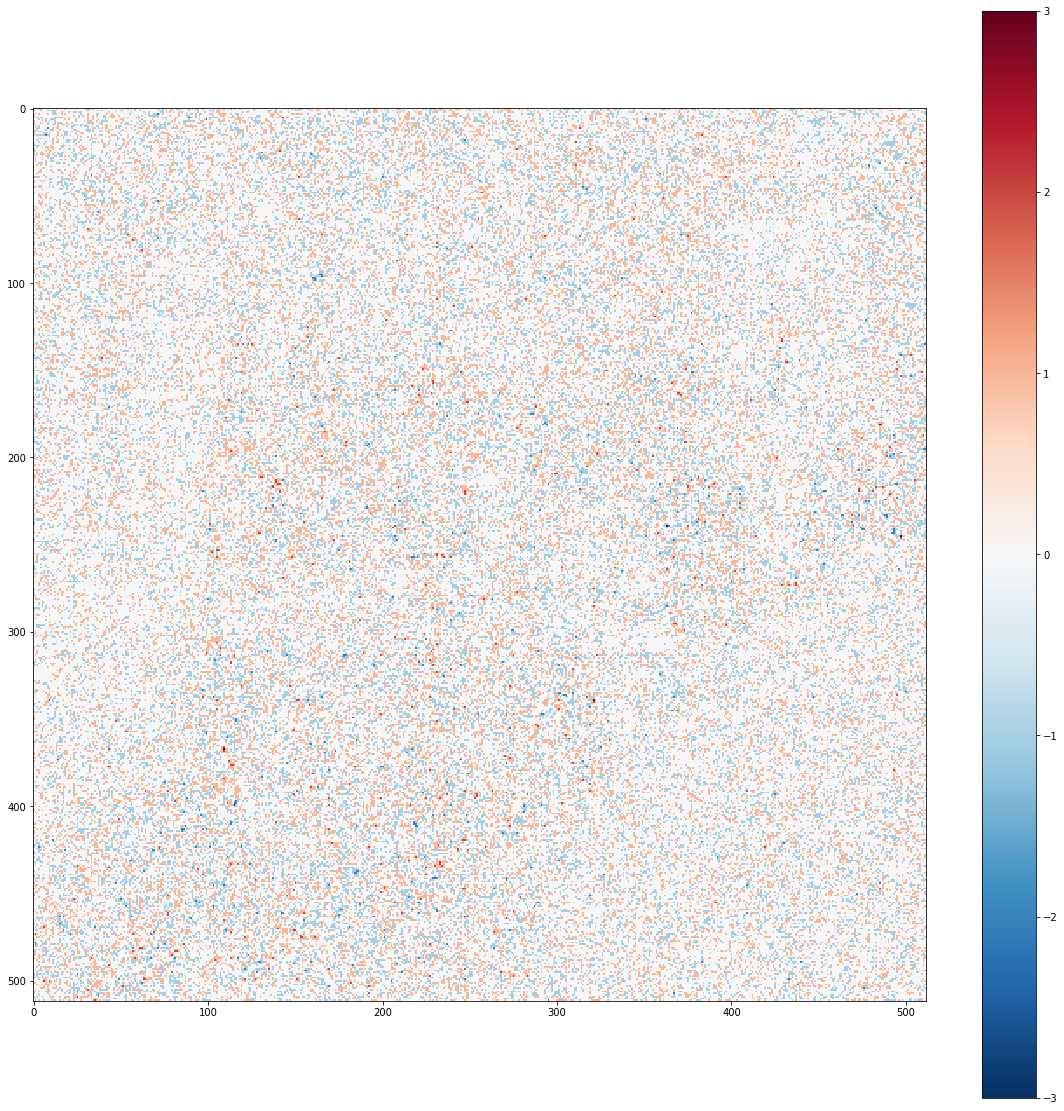

In [18]:
file = '6934.nef'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 100
x2 = x1 + 512
y1 = 500
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### 4750.cr2

4750.cr2
Coordonnées RAW : (1900, 2300)
Coordonnées JPEG : (1900, 2300)
0
1
Temps : 2.2333223819732666


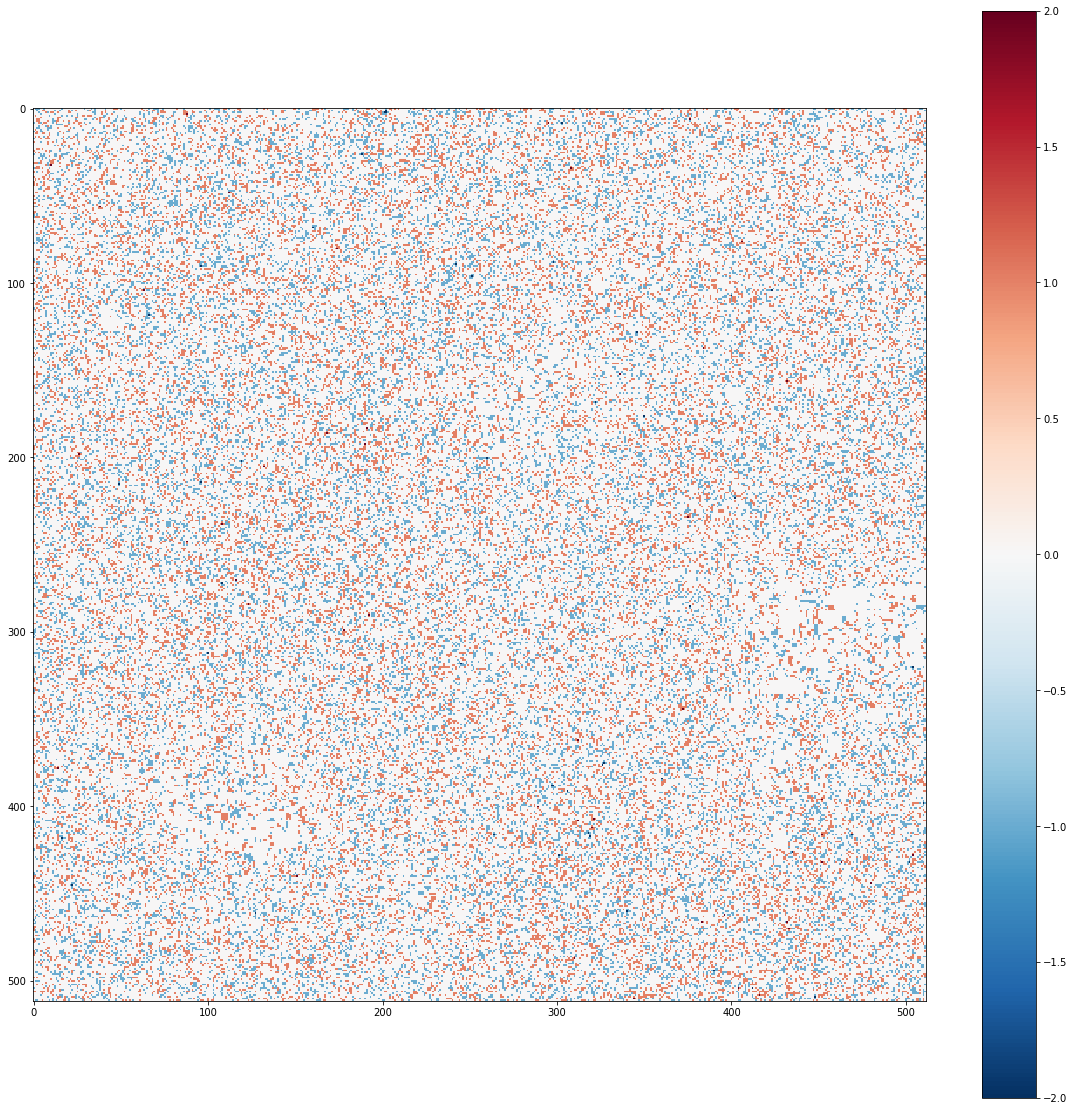

In [19]:
file = '4750.cr2'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1900
x2 = x1 + 512
y1 = 2300
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono3.DNG

Mono3.DNG
Coordonnées RAW : (1900, 2300)
Coordonnées JPEG : (2300, 1060)
0
1
Temps : 1.3919663429260254


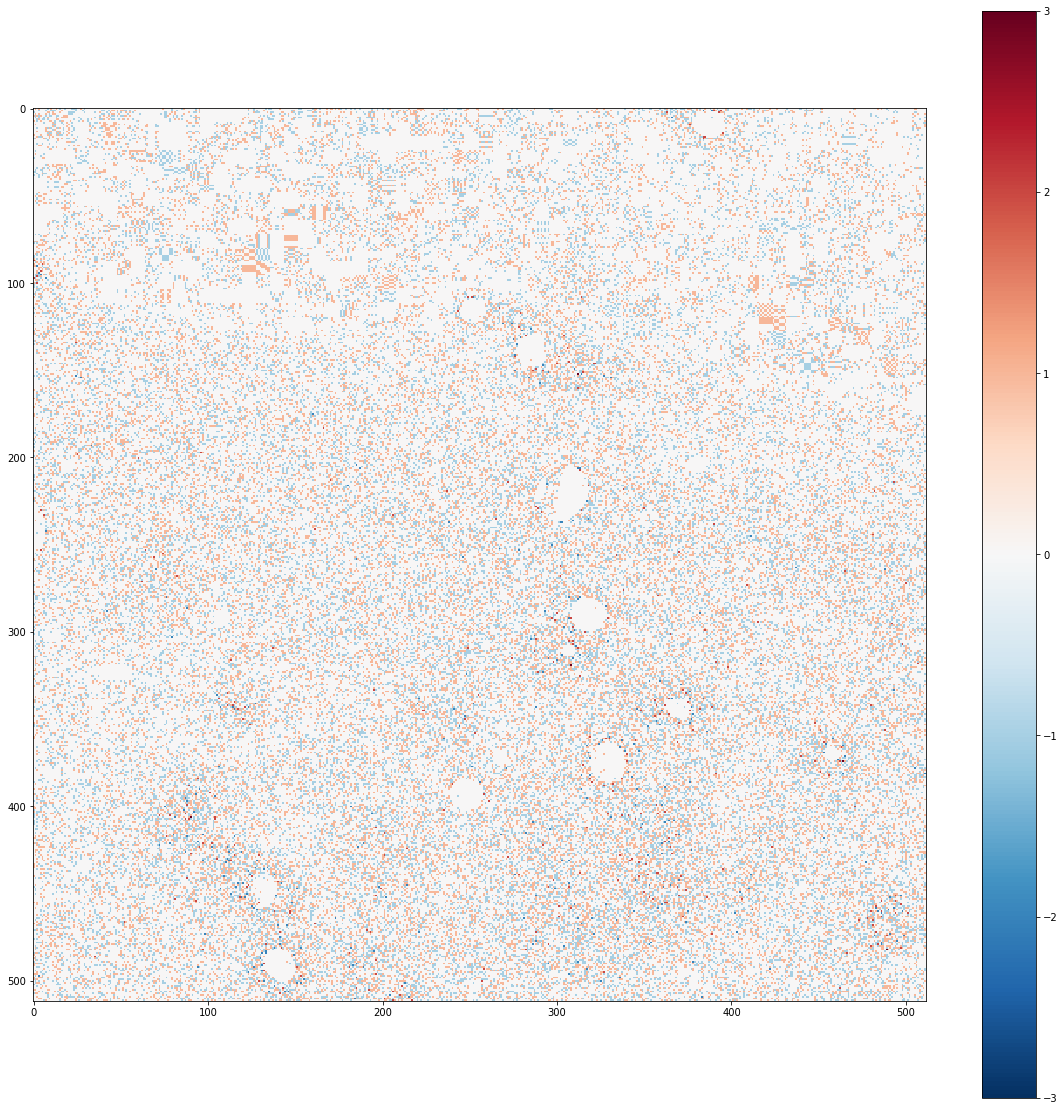

In [20]:
file = 'Mono3.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1900
x2 = x1 + 512
y1 = 2300
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

#### Mono2.DNG

Mono2.DNG
Coordonnées RAW : (1200, 3200)
Coordonnées JPEG : (1200, 3200)
0
1
Temps : 1.2082479000091553


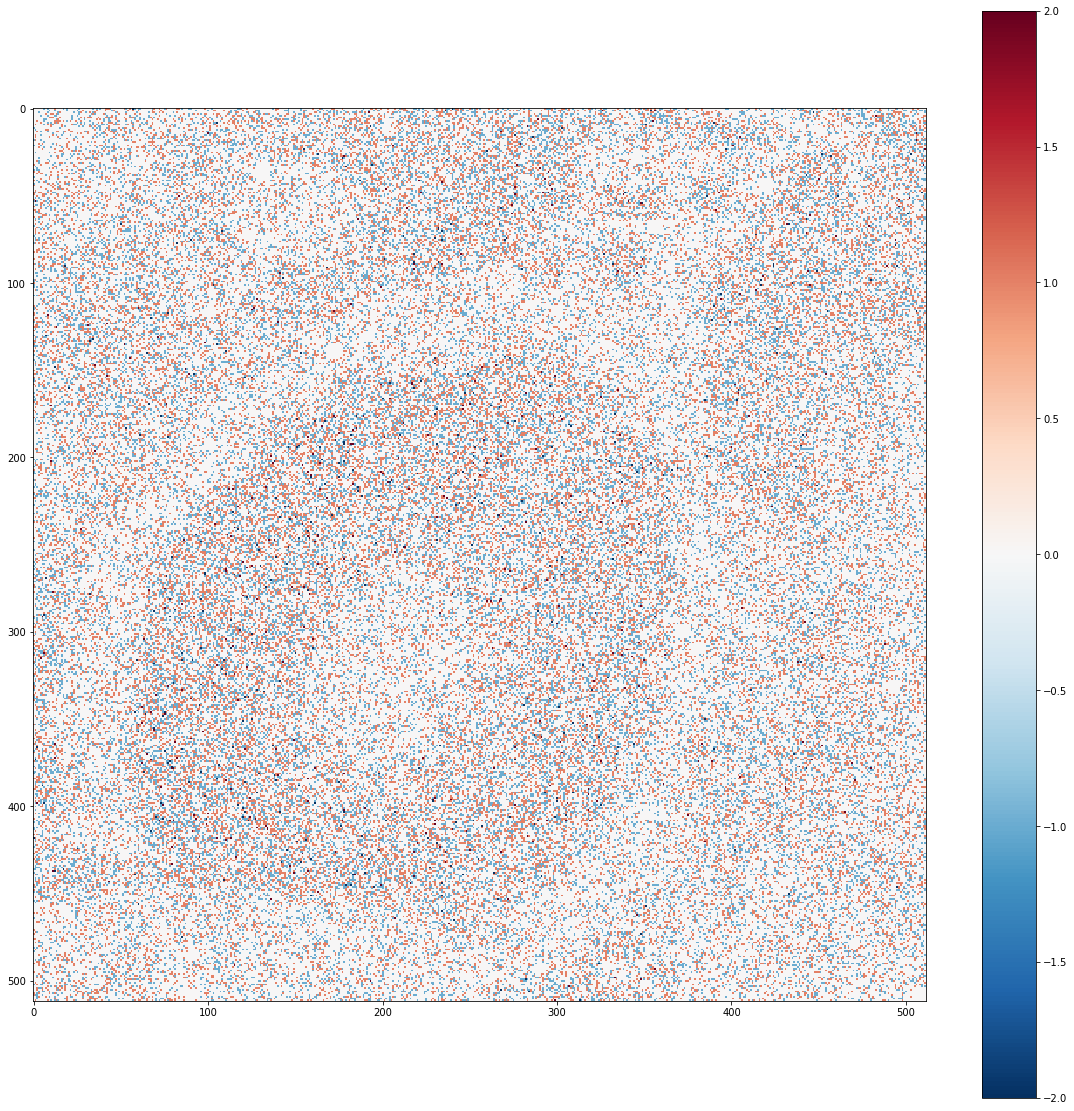

In [22]:
file = 'Mono2.DNG'
print(file)
cover_file = path + file
raw_im = rawpy.imread(cover_file)

conf.generate.NS.jpeg = True
conf.generate.NS.dev = 'python'
conf.generate.NS.mono = True
conf.embed.NS.a = 0.05 # Mono 1000 -> 1250: a = 1.37
conf.embed.NS.b = 0 # Mono 1000 -> 1250: a = 3607
conf.embed.cover_path = path
conf.embed.pseudo_cover_path = './Pseudo_Cover/' + file + '/'

if not os.path.exists('./Pseudo_Cover/'):
    os.mkdir('./Pseudo_Cover/')

if not os.path.exists(conf.embed.pseudo_cover_path):
    os.mkdir(conf.embed.pseudo_cover_path)

conf.imgs.QF = 100

x1 = 1200
x2 = x1 + 512
y1 = 3200
y2 = y1 + 512

im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

if im_cover.shape != (512, 512):
    print("Attention : Crop non pris en charge, x1/y1 trop grand")
    x2, y2 = raw_im.raw_image_visible.shape
    print("Taille de l'image :", (x2, y2))
    x1 = x2 - 512
    y1 = y2 - 512
    print("Début du crop modifié :", (x1, y1))
    im_cover = raw_im.raw_image_visible[x1:x2,y1:y2]

nb_bits = 14
lvl_max = 2**nb_bits-1

a = conf.embed.NS.a #0.8# * 2**nb_bits 
b = conf.embed.NS.b #-800# * 2**(2*nb_bits)

im_pseudo_cover = np.zeros((512 ,512))
var_pseudo_cover_signal = im_cover[:,:]*a+b
var_pseudo_cover_signal[var_pseudo_cover_signal<0]=0
var_pseudo_cover_signal = np.sqrt(var_pseudo_cover_signal)

x, y = seek_co()
print("Coordonnées RAW :", (x1, y1))
print("Coordonnées JPEG :", (x, y))

generate_pool(n)

im_0 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_0.jpg') 
im_1 = imread(conf.embed.pseudo_cover_path + cover_file[7:-4] + '_1.jpg') 

im_0 = im_0.astype('float')
im_1 = im_1.astype('float')

plt.figure(figsize = (20, 20))
DIFF = im_0 - im_1 #
val_max = np.max(np.abs(im_0 - im_1))
plt.imshow(DIFF, cmap='RdBu_r', vmax = val_max, vmin = -val_max)
plt.colorbar()

In [23]:
print("Temps total :", time() - u)

Temps total : 108.24958634376526
